In [1]:
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data - FIXED QUERY
TRANSACTION_QUERY = """
WITH base AS (
  SELECT
    customer_id,
    case when market = 'us' then 'US'
    when market = 'uk' then 'UK'
    else 'EU' end as market,
    transaction_completed_datetime
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
),
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(transaction_completed_datetime ORDER BY transaction_completed_datetime) AS txns
  FROM base
  GROUP BY customer_id, market
)
SELECT
  customer_id,
  market,
  DATE(txns[OFFSET(0)]) AS first_txn_date,
  CASE 
    WHEN ARRAY_LENGTH(txns) >= 2 THEN
      DATE_DIFF(DATE(txns[OFFSET(1)]), DATE(txns[OFFSET(0)]), DAY)
    ELSE 0
  END AS days_between_first_and_second
FROM first_two;
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'first_txn_date': 'datetime64[ns]',
    'days_between_first_and_second': 'int32'
}

df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


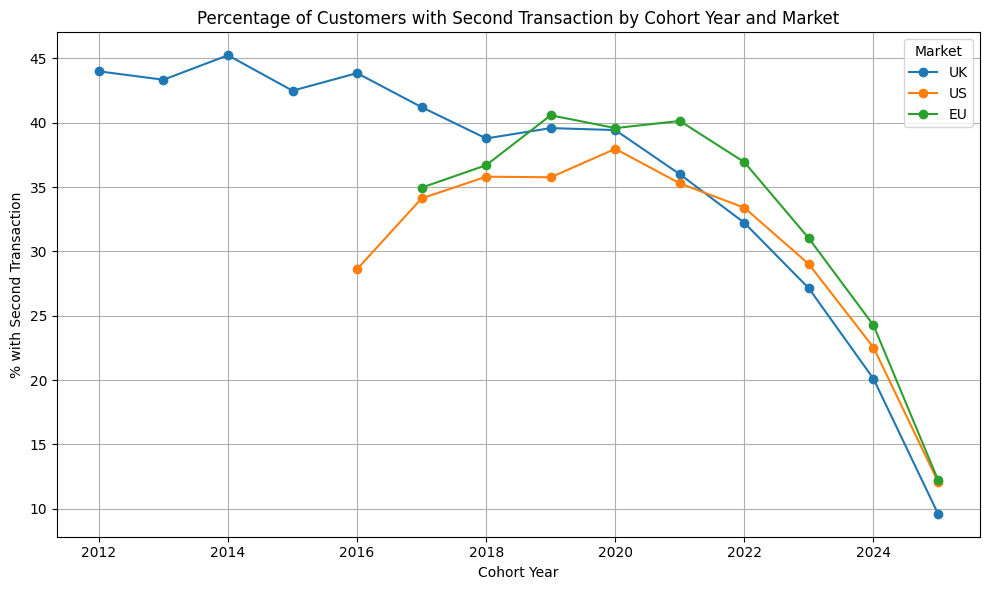

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract cohort year
df['cohort_year'] = pd.to_datetime(df['first_txn_date']).dt.year

# Flag customers with a second transaction
df['has_second_txn'] = df['days_between_first_and_second'] > 0

# Group by cohort year and market, calculate percentage
summary = (
    df.groupby(['cohort_year', 'market'])
      .agg(total_customers=('customer_id', 'count'),
           second_txn_customers=('has_second_txn', 'sum'))
      .reset_index()
)
summary['pct_with_second_txn'] = summary['second_txn_customers'] / summary['total_customers'] * 100

# Plot
plt.figure(figsize=(10,6))
for market in summary['market'].unique():
    market_data = summary[summary['market'] == market]
    plt.plot(market_data['cohort_year'], market_data['pct_with_second_txn'], marker='o', label=market)

plt.xlabel('Cohort Year')
plt.ylabel('% with Second Transaction')
plt.title('Percentage of Customers with Second Transaction by Cohort Year and Market')
plt.legend(title='Market')
plt.grid(True)
plt.tight_layout()
plt.show()

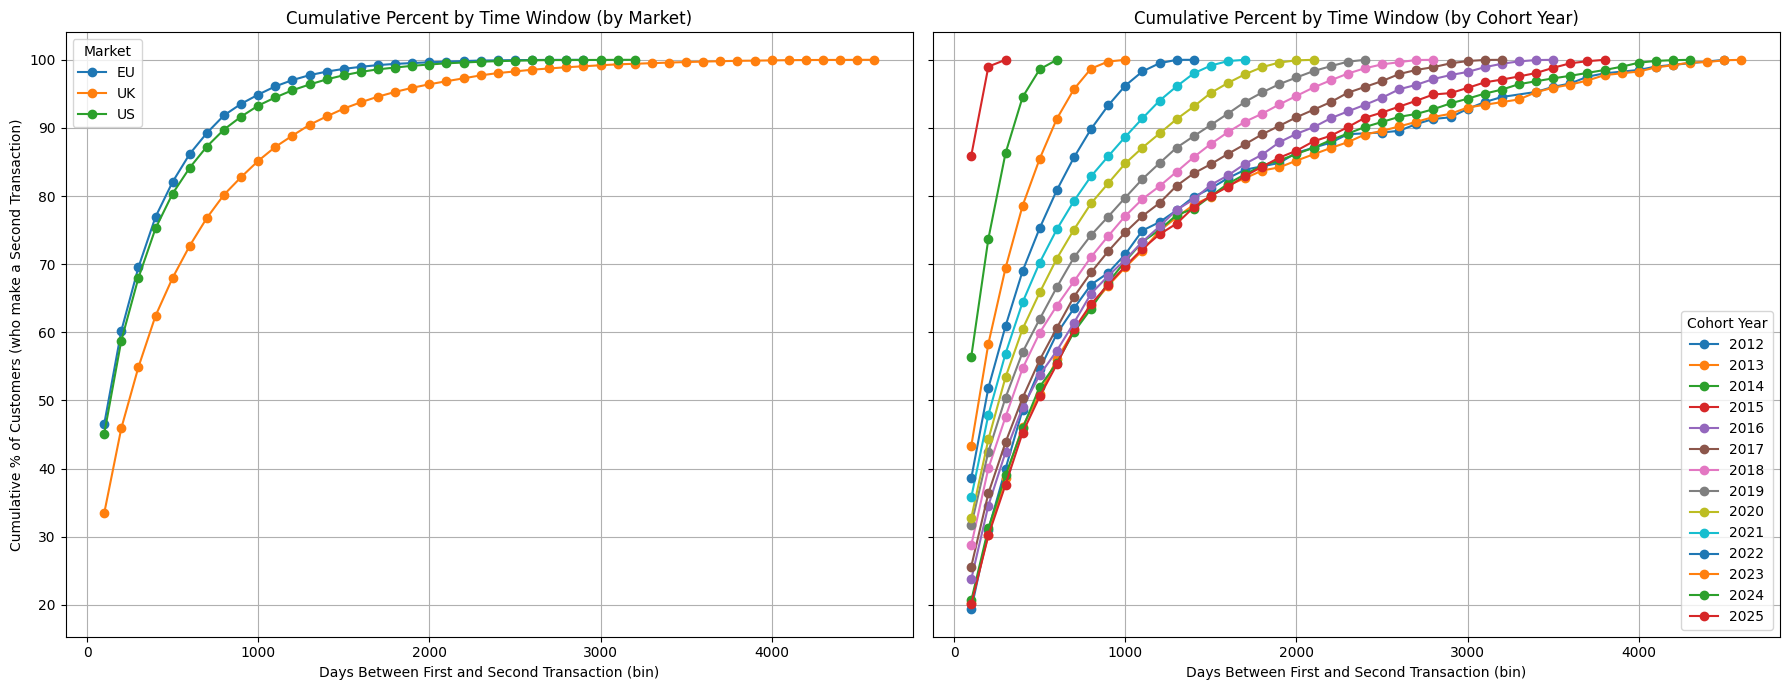

In [7]:
# Filter to only customers with a second transaction
df2 = df[df['days_between_first_and_second'] > 0].copy()

# Bin days into intervals of 100 days
bins = range(0, df2['days_between_first_and_second'].max() + 101, 100)
labels = bins[1:]
df2['days_bin'] = pd.cut(df2['days_between_first_and_second'], bins=bins, labels=labels, right=True)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# First plot: cumulative percent by market
for market in df2['market'].unique():
    data = df2[df2['market'] == market]
    total = len(data)
    # For each bin, cumulative count up to that bin
    cum_counts = data.groupby('days_bin', observed=True).size().cumsum()
    cum_pct = cum_counts / total * 100
    axes[0].plot(cum_pct.index.astype(int), cum_pct.values, marker='o', label=market)
axes[0].set_xlabel('Days Between First and Second Transaction (bin)')
axes[0].set_ylabel('Cumulative % of Customers (who make a Second Transaction)')
axes[0].set_title('Cumulative Percent by Time Window (by Market)')
axes[0].legend(title='Market')
axes[0].grid(True)

# Second plot: cumulative percent by cohort year
for year in sorted(df2['cohort_year'].unique()):
    data = df2[df2['cohort_year'] == year]
    total = len(data)
    cum_counts = data.groupby('days_bin', observed=True).size().cumsum()
    cum_pct = cum_counts / total * 100
    axes[1].plot(cum_pct.index.astype(int), cum_pct.values, marker='o', label=str(year))
axes[1].set_xlabel('Days Between First and Second Transaction (bin)')
axes[1].set_title('Cumulative Percent by Time Window (by Cohort Year)')
axes[1].legend(title='Cohort Year')
axes[1].grid(True)

plt.tight_layout()
plt.show()